In [35]:
FULL_TRAINING = False

import numpy as np
import pandas as pd
from pynvml import *
import torch
from torch.utils.data import Dataset
from PIL import Image
from transformers import VisionEncoderDecoderModel, AutoTokenizer

def print_gpu_utilization():
    nvmlInit()
    handle = nvmlDeviceGetHandleByIndex(0)
    info = nvmlDeviceGetMemoryInfo(handle)
    print(f"GPU memory occupied: {info.used//1024**2} MB.")


def print_summary(result):
    print(f"Time: {result.metrics['train_runtime']:.2f}")
    print(f"Samples/second: {result.metrics['train_samples_per_second']:.2f}")
    print_gpu_utilization()
    
default_path = "C:/Users/Jo/PYDATAexam/train/" 
df = pd.read_csv('../train.csv')

df.rename(columns={'img_path': "file_name", "label": "text"}, inplace=True)
df['text'] = df['text'].str.strip()
df['file_name'] = df['file_name'].apply(lambda x: default_path + x.split('/')[2])

# Just for hands-on lab
if not FULL_TRAINING:
    df = df.sample(n=1000, random_state=42)

In [36]:
df.shape

(1000, 3)

In [37]:
if FULL_TRAINING:
    vision_hf_model = 'facebook/deit-base-distilled-patch16-384'
    nlp_hf_model = "klue/roberta-base"
    
    # Reference: https://github.com/huggingface/transformers/issues/15823
    # initialize the encoder from a pretrained ViT and the decoder from a pretrained BERT model. 
    # Note that the cross-attention layers will be randomly initialized, and need to be fine-tuned on a downstream dataset
    model = VisionEncoderDecoderModel.from_encoder_decoder_pretrained(vision_hf_model, nlp_hf_model)
    tokenizer = AutoTokenizer.from_pretrained(nlp_hf_model)
else:
    trocr_model = 'daekeun-ml/ko-trocr-base-nsmc-news-chatbot'
    model = VisionEncoderDecoderModel.from_pretrained(trocr_model)
    tokenizer = AutoTokenizer.from_pretrained(trocr_model)     

loading configuration file config.json from cache at C:\Users\Jo/.cache\huggingface\hub\models--daekeun-ml--ko-trocr-base-nsmc-news-chatbot\snapshots\b8e0ab4b7ef7c686a23654e24ffd6ebe36bb59da\config.json
Model config VisionEncoderDecoderConfig {
  "_commit_hash": "b8e0ab4b7ef7c686a23654e24ffd6ebe36bb59da",
  "_name_or_path": "daekeun-ml/ko-trocr-base-nsmc-news-chatbot",
  "architectures": [
    "VisionEncoderDecoderModel"
  ],
  "decoder": {
    "_name_or_path": "",
    "add_cross_attention": true,
    "architectures": [
      "RobertaForMaskedLM"
    ],
    "attention_probs_dropout_prob": 0.1,
    "bad_words_ids": null,
    "begin_suppress_tokens": null,
    "bos_token_id": 0,
    "chunk_size_feed_forward": 0,
    "classifier_dropout": null,
    "cross_attention_hidden_size": null,
    "decoder_start_token_id": null,
    "diversity_penalty": 0.0,
    "do_sample": false,
    "early_stopping": false,
    "encoder_no_repeat_ngram_size": 0,
    "eos_token_id": 2,
    "exponential_decay_len

In [38]:
from sklearn.model_selection import train_test_split

train_df, test_df = train_test_split(df, test_size=0.1)
train_df.reset_index(drop=True, inplace=True)
test_df.reset_index(drop=True, inplace=True)

In [39]:
class OCRDataset(Dataset):
    def __init__(self, df, processor, tokenizer, max_target_length=32):
        self.df = df
        self.processor = processor
        self.max_target_length = max_target_length
        self.tokenizer = tokenizer

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        # get file name + text 
        file_name = self.df['file_name'][idx]
        text = self.df['text'][idx]
        # prepare image (i.e. resize + normalize)
        image = Image.open(file_name).convert("RGB")
        pixel_values = self.processor(image, return_tensors="pt").pixel_values
        # add labels (input_ids) by encoding the text      
        labels = self.tokenizer(text, padding="max_length", 
                                stride=32,
                                truncation=True,
                                max_length=self.max_target_length).input_ids
        
        # important: make sure that PAD tokens are ignored by the loss function
        labels = [label if label != self.tokenizer.pad_token_id else -100 for label in labels]

        encoding = {"pixel_values": pixel_values.squeeze(), "labels": torch.tensor(labels)}
        return encoding

In [40]:
from transformers import TrOCRProcessor
processor = TrOCRProcessor.from_pretrained("microsoft/trocr-base-handwritten")
max_length = 64

train_dataset = OCRDataset(
    #dataset_dir=dataset_dir,
    df=train_df,
    tokenizer=tokenizer,
    processor=processor,
    max_target_length=max_length
)
eval_dataset = OCRDataset(
    #dataset_dir=dataset_dir,
    df=test_df,
    tokenizer=tokenizer,
    processor=processor,
    max_target_length=max_length
)

print("Number of training examples:", len(train_dataset))
print("Number of validation examples:", len(eval_dataset))

loading configuration file preprocessor_config.json from cache at C:\Users\Jo/.cache\huggingface\hub\models--microsoft--trocr-base-handwritten\snapshots\69659a277424eb381574e4952f3b3fa3440a419b\preprocessor_config.json
Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration.
{param_name} should be a dictionary on of the following set of keys: {VALID_SIZE_DICT_KEYS}, got {size}. Converted to {size_dict}.
Image processor ViTImageProcessor {
  "do_normalize": true,
  "do_rescale": true,
  "do_resize": true,
  "image_mean": [
    0.5,
    0.5,
    0.5
  ],
  "image_processor_type": "ViTImageProcessor",
  "image_std": [
    0.5,
    0.5,
    0.5
  ],
  "resample": 2,
  "rescale_factor": 0.00392156862745098,
  "size": {
    "height": 384,
    "width": 384
  }
}

loading file vocab.json from cache at C:\Users\Jo/.cache\huggingface\hub\models--microsoft--trocr-base-handwritten\sna

Number of training examples: 900
Number of validation examples: 100


pixel_values torch.Size([3, 384, 384])
labels torch.Size([64])


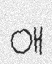

In [41]:
img_idx = np.random.randint(len(train_df))
encoding = train_dataset[img_idx]
for k,v in encoding.items():
    print(k, v.shape)
    
image = Image.open(train_df['file_name'][img_idx]).convert("RGB")
image    

In [42]:
labels = encoding['labels']
labels[labels == -100] = tokenizer.pad_token_id
label_str = tokenizer.decode(labels, skip_special_tokens=True)
print(label_str)

애


In [43]:
# set special tokens used for creating the decoder_input_ids from the labels
model.config.decoder_start_token_id = tokenizer.cls_token_id
model.config.pad_token_id = tokenizer.pad_token_id
model.config.vocab_size = model.config.decoder.vocab_size

# set beam search parameters
model.config.eos_token_id = tokenizer.sep_token_id
model.config.max_length = max_length
model.config.early_stopping = True
model.config.no_repeat_ngram_size = 3
model.config.length_penalty = 2.0
model.config.num_beams = 4

In [44]:
from transformers import Seq2SeqTrainer, Seq2SeqTrainingArguments

training_args = Seq2SeqTrainingArguments(
    predict_with_generate=True,
    evaluation_strategy="steps",
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=1,
    learning_rate=4e-5,
    output_dir="./",
    logging_dir="./logs",
    logging_steps=10,
    save_steps=5000,
    eval_steps=5000,
)

PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).


In [45]:
import evaluate
cer_metric = evaluate.load("cer")
wer_metric = evaluate.load("wer")

In [46]:
def compute_metrics(pred):
    labels_ids = pred.label_ids
    pred_ids = pred.predictions

    pred_str = tokenizer.batch_decode(pred_ids, skip_special_tokens=True)
    labels_ids[labels_ids == -100] = processor.tokenizer.pad_token_id
    label_str = tokenizer.batch_decode(labels_ids, skip_special_tokens=True)

    cer = cer_metric.compute(predictions=pred_str, references=label_str)
    wer = wer_metric.compute(predictions=pred_str, references=label_str)

    return {"cer": cer, "wer": wer}

In [47]:
from transformers import default_data_collator

# instantiate trainer
trainer = Seq2SeqTrainer(
    model=model,
    tokenizer=tokenizer,
    args=training_args,
    compute_metrics=compute_metrics,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    data_collator=default_data_collator,
)

In [48]:
print_gpu_utilization()

GPU memory occupied: 164 MB.


In [49]:
result = trainer.train()

C:\Users\Jo\anaconda3\lib\site-packages\transformers\optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 900
  Num Epochs = 1
  Instantaneous batch size per device = 16
  Total train batch size (w. parallel, distributed & accumulation) = 16
  Gradient Accumulation steps = 1
  Total optimization steps = 57
  Number of trainable parameters = 225701120
Trainer is attempting to log a value of "{'return_dict': True, 'output_hidden_states': False, 'output_attentions': False, 'torchscript': False, 'torch_dtype': None, 'use_bfloat16': False, 'tf_legacy_loss': False, 'pruned_heads': {}, 'tie_word_embeddings': True, 'is_encoder_decoder': False, 'is_decoder': True, 'cross_attention_hidden_size': None, 'add_cross_attention': True, 'tie_encoder_decoder'

Step,Training Loss,Validation Loss




Training completed. Do not forget to share your model on huggingface.co/models =)




In [ ]:
if FULL_TRAINING:
    steps = []
    losses = []
    for obj in trainer.state.log_history:
        steps.append(obj['step'])
        losses.append(obj['loss'])

    import matplotlib.pyplot as plt
    f = plt.figure(figsize=(12,6))
    plt.plot(steps, losses)
    plt.xlabel('step')
    plt.ylabel('training loss')
    plt.show()    

In [53]:
trainer.save_model(output_dir="./model")

Saving model checkpoint to ./model
Configuration saved in ./model\config.json
Model weights saved in ./model\pytorch_model.bin
tokenizer config file saved in ./model\tokenizer_config.json
Special tokens file saved in ./model\special_tokens_map.json


In [52]:
model.eval()
with torch.no_grad():
    eval_result = trainer.evaluate(eval_dataset, max_length=64)  

***** Running Evaluation *****
  Num examples = 100
  Batch size = 16


KeyboardInterrupt: 

In [ ]:
eval_result

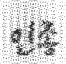

In [54]:
import glob
img_paths = glob.glob('../test/*.png')
img_idx = np.random.randint(len(img_paths))
image = Image.open(img_paths[img_idx])
#img_idx = np.random.randint(len(eval_dataset))
#image = Image.open(eval_dataset.dataset_dir + train_df['file_name'][img_idx])
image

In [55]:
len(img_paths)

74121

In [56]:
from transformers import TrOCRProcessor, VisionEncoderDecoderModel

pixel_values = (processor(image, return_tensors="pt").pixel_values)
generated_ids = model.generate(pixel_values)
generated_text = tokenizer.batch_decode(generated_ids, skip_special_tokens=True)[0] 
generated_ids, generated_text

C:\Users\Jo\anaconda3\lib\site-packages\transformers\generation\utils.py:1387: UserWarning: Neither `max_length` nor `max_new_tokens` has been set, `max_length` will default to 64 (`self.config.max_length`). Controlling `max_length` via the config is deprecated and `max_length` will be removed from the config in v5 of Transformers -- we recommend using `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


(tensor([[   0,    0, 1506, 2728,    2]]), '인것')

# Predict

In [ ]:
from tqdm import tqdm

preds = []

for path in tqdm(img_paths[:20000]):
    image = Image.open(path)
    pixel_values = (processor(image, return_tensors="pt").pixel_values)
    generated_ids = model.generate(pixel_values)
    generated_text = tokenizer.batch_decode(generated_ids, skip_special_tokens=True)[0] 
    preds.append(generated_text)

 33%|████████████████████████▍                                                | 6698/20000 [4:40:28<9:07:11,  2.47s/it]

In [32]:
submission = pd.read_csv("../sample_submission.csv")
submission.head()

,id,label
0,TEST_00000,가
1,TEST_00001,가
2,TEST_00002,가
3,TEST_00003,가
4,TEST_00004,가


In [33]:
preds

['닭닭',
 '삶상',
 '받다',
 '바꾸다',
 '실',
 '배타다',
 '인식하다',
 '센터',
 '쇼핑몰',
 '광주',
 '그대',
 '무청',
 '도구',
 '승',
 '괴로워하다',
 '카드',
 '답답하다',
 '감사하다',
 '달자',
 '가스하다']

In [34]:
test_df

,id,file_name,text
0,TRAIN_65647,C:/Users/Jo/PYDATAexam/train/TRAIN_65647.png,던
1,TRAIN_22304,C:/Users/Jo/PYDATAexam/train/TRAIN_22304.png,갚
2,TRAIN_28921,C:/Users/Jo/PYDATAexam/train/TRAIN_28921.png,지적
3,TRAIN_21995,C:/Users/Jo/PYDATAexam/train/TRAIN_21995.png,맘대로
4,TRAIN_61489,C:/Users/Jo/PYDATAexam/train/TRAIN_61489.png,면
5,TRAIN_29108,C:/Users/Jo/PYDATAexam/train/TRAIN_29108.png,좀
6,TRAIN_48261,C:/Users/Jo/PYDATAexam/train/TRAIN_48261.png,아버지
7,TRAIN_62937,C:/Users/Jo/PYDATAexam/train/TRAIN_62937.png,음성
8,TRAIN_08504,C:/Users/Jo/PYDATAexam/train/TRAIN_08504.png,향기
9,TRAIN_22583,C:/Users/Jo/PYDATAexam/train/TRAIN_22583.png,만
